<h1>521H0287 - Văn Công Nguyên Phong</h1>
<h1>521H0285 - Phạm Trần Tiến Phát</h1>
<h1>521H0302 - Trương Công Thành</h1>

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from scipy.stats import zscore, boxcox
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import StratifiedKFold
import warnings

warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)

In [2]:
current_directory = os.getcwd()
csv_filename = 'data.csv'
csv_path = os.path.join(current_directory, "data" ,csv_filename)

In [3]:
billionaires = pd.read_csv(csv_path)
billionaires.head(5)    

,rank,finalWorth,category,personName,age,country,city,source,industries,countryOfCitizenship,organization,selfMade,status,gender,birthDate,lastName,firstName,title,date,state,residenceStateRegion,birthYear,birthMonth,birthDay,cpi_country,cpi_change_country,gdp_country,gross_tertiary_education_enrollment,gross_primary_education_enrollment_country,life_expectancy_country,tax_revenue_country_country,total_tax_rate_country,population_country,latitude_country,longitude_country
0,1,211000,Fashion & Retail,Bernard Arnault & family,74.0,France,Paris,LVMH,Fashion & Retail,France,LVMH Moët Hennessy Louis Vuitton,False,U,M,3/5/1949 0:00,Arnault,Bernard,Chairman and CEO,4/4/2023 5:01,NaN,NaN,1949.0,3.0,5.0,110.05,1.1,"$2,715,518,274,227",65.6,102.5,82.5,24.2,60.7,67059887.0,46.227638,2.213749
1,2,180000,Automotive,Elon Musk,51.0,United States,Austin,"Tesla, SpaceX",Automotive,United States,Tesla,True,D,M,6/28/1971 0:00,Musk,Elon,CEO,4/4/2023 5:01,Texas,South,1971.0,6.0,28.0,117.24,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
2,3,114000,Technology,Jeff Bezos,59.0,United States,Medina,Amazon,Technology,United States,Amazon,True,D,M,1/12/1964 0:00,Bezos,Jeff,Chairman and Founder,4/4/2023 5:01,Washington,West,1964.0,1.0,12.0,117.24,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
3,4,107000,Technology,Larry Ellison,78.0,United States,Lanai,Oracle,Technology,United States,Oracle,True,U,M,8/17/1944 0:00,Ellison,Larry,CTO and Founder,4/4/2023 5:01,Hawaii,West,1944.0,8.0,17.0,117.24,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
4,5,106000,Finance & Investments,Warren Buffett,92.0,United States,Omaha,Berkshire Hathaway,Finance & Investments,United States,Berkshire Hathaway Inc. (Cl A),True,D,M,8/30/1930 0:00,Buffett,Warren,CEO,4/4/2023 5:01,Nebraska,Midwest,1930.0,8.0,30.0,117.24,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891


In [4]:
billionaires.describe()
billionaires['selfMade'] = billionaires['selfMade'].astype("object")

In [5]:
## Getting total of missing values
billionaires.isna().sum().sort_values(ascending = False)

organization                                  2315
title                                         2301
residenceStateRegion                          1893
state                                         1887
cpi_change_country                             184
cpi_country                                    184
tax_revenue_country_country                    183
total_tax_rate_country                         182
life_expectancy_country                        182
gross_tertiary_education_enrollment            182
gross_primary_education_enrollment_country     181
latitude_country                               164
population_country                             164
gdp_country                                    164
longitude_country                              164
birthDate                                       76
birthYear                                       76
birthMonth                                      76
birthDay                                        76
city                           

In [6]:
billionaires.columns
# Specifying input and target variables
columns_to_drop = ['personName', 'lastName', 'firstName', 'birthYear', 'birthMonth',
                   'birthDay', 'birthDate', 'date', 'organization', 'residenceStateRegion', 'state',
                   'title']

billionaires.drop(columns=columns_to_drop, axis=1, inplace=True)

cat = billionaires.select_dtypes(include="object").columns
num = billionaires.select_dtypes(include=['int', 'float']).columns

In [7]:
for i in billionaires.columns:
    if i in cat:
        billionaires[i] = billionaires[i].fillna(billionaires[i].mode()[0])
    else:
        avg = billionaires[i].mean()
        md = billionaires[i].median()
        mod = billionaires[i].mode()

        # Predict missing values        
        imputer = KNNImputer(n_neighbors=3)
        knr = imputer.fit_transform(billionaires[num])

        # Choice one values from randomly
        rn_index = np.random.choice(3)
        bf = billionaires[i].shift(-1).iloc[rn_index]
        af = billionaires[i].shift(+1).iloc[rn_index]

        n = [avg, md, mod.values[0], bf, af, knr[rn_index][rn_index]]

        rn_value = n[rn_index]
        rn_value

        # Fill data by selected value
        billionaires[i] = billionaires[i].fillna(rn_value)

In [8]:
billionaires.isna().sum()/len(billionaires)*100

rank                                          0.0
finalWorth                                    0.0
category                                      0.0
age                                           0.0
country                                       0.0
city                                          0.0
source                                        0.0
industries                                    0.0
countryOfCitizenship                          0.0
selfMade                                      0.0
status                                        0.0
gender                                        0.0
cpi_country                                   0.0
cpi_change_country                            0.0
gdp_country                                   0.0
gross_tertiary_education_enrollment           0.0
gross_primary_education_enrollment_country    0.0
life_expectancy_country                       0.0
tax_revenue_country_country                   0.0
total_tax_rate_country                        0.0


In [9]:
billionaires[num].skew()

rank                                          -0.006357
finalWorth                                    10.012367
age                                           -0.078245
cpi_country                                    2.707725
cpi_change_country                             4.472554
gross_tertiary_education_enrollment           -0.234110
gross_primary_education_enrollment_country     2.436038
life_expectancy_country                       -1.095459
tax_revenue_country_country                    1.673160
total_tax_rate_country                         0.218546
population_country                             0.893157
latitude_country                              -1.788847
longitude_country                             -0.017251
dtype: float64

In [10]:
billionaires['finalWorth'] = boxcox(billionaires['finalWorth'])[0]

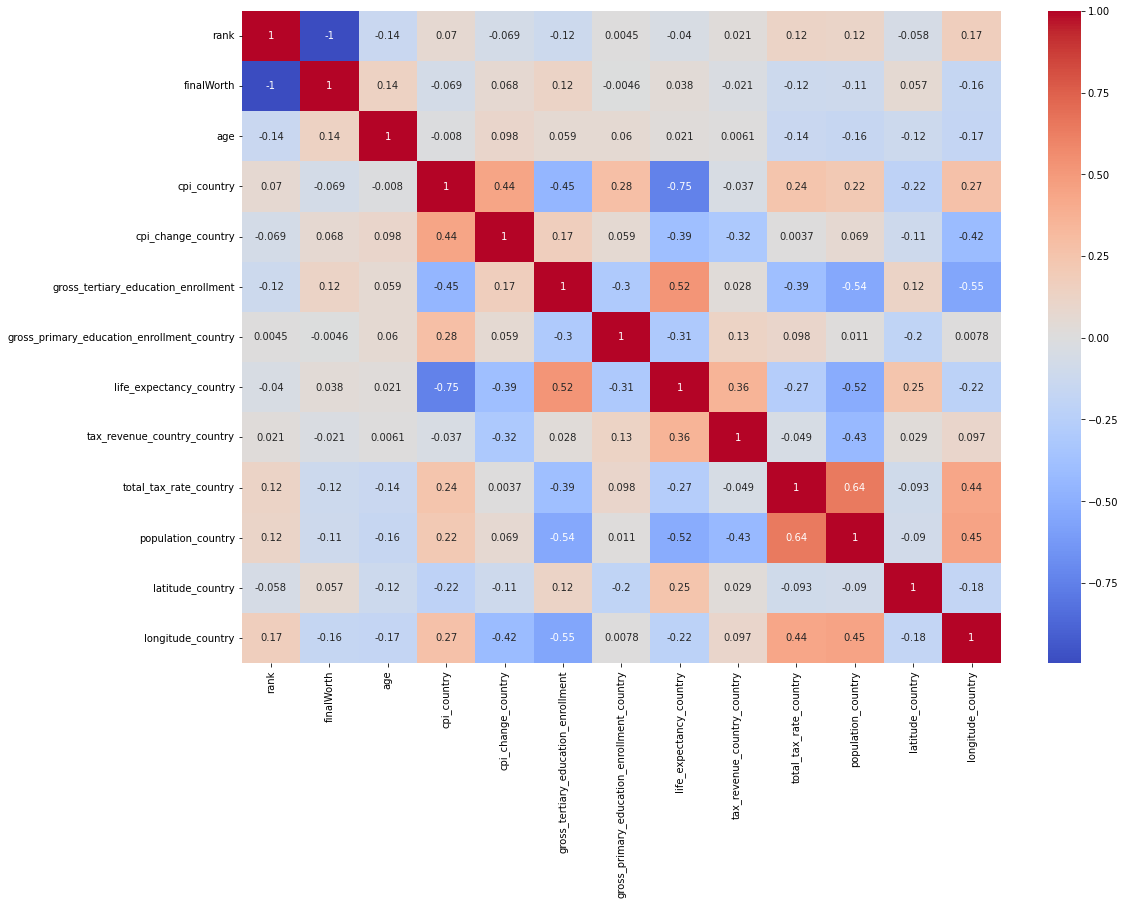

In [11]:
plt.figure(figsize=(17,12))
sns.heatmap(billionaires[num].corr(),annot=True, cmap='coolwarm')
plt.show()

In [12]:
dict_le = {}

for i in cat:
    dict_le[i] = LabelEncoder()
    billionaires[i] = dict_le[i].fit_transform(billionaires[i])

# billionaires[num] = scaler.fit_transform(billionaires[num])

In [13]:
scaler = StandardScaler()
x = billionaires.drop('selfMade',axis=1)
y = billionaires['selfMade']

In [14]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=45)

In [15]:
# importing ML libraries 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

In [16]:
lr = LogisticRegression(solver='sag')
dt = DecisionTreeClassifier(min_samples_split=2, min_samples_leaf = 1 , max_depth=200)
rn = RandomForestClassifier()
knn = KNeighborsClassifier()
gb = GaussianNB()
sgd = SGDClassifier()
bc = BaggingClassifier()
ada = AdaBoostClassifier()
kn = KNeighborsClassifier(n_neighbors=3)

In [17]:
rn = RandomForestClassifier(    
    bootstrap=True,
    max_features=0.825,
    min_samples_leaf=4,
    min_samples_split=2,
    n_estimators= 300 )

In [18]:
li = [lr,sgd,knn,gb,rn,dt,bc]
di = {}
for i in li:
    i.fit(xtrain, ytrain)
    ypred = i.predict(xtest)

    accuracy = accuracy_score(ytest, ypred)
    precision = precision_score(ytest, ypred, average='weighted')
    recall = recall_score(ytest, ypred, average='weighted')
    f1 = f1_score(ytest, ypred, average='weighted')
    print(f"{i}: Accuracy - {accuracy:.4f}, Precision - {precision:.4f}, Recall - {recall:.4f}, F1 Score - {f1:.4f}")

    # print(i,":",r2_score(ypred,ytest))
    di.update({str(i):{i.score(xtrain,ytrain)*100, i.score(xtest,ytest)*100}})

LogisticRegression(solver='sag'): Accuracy - 0.6831, Precision - 0.4666, Recall - 0.6831, F1 Score - 0.5545
SGDClassifier(): Accuracy - 0.6831, Precision - 0.4666, Recall - 0.6831, F1 Score - 0.5545
KNeighborsClassifier(): Accuracy - 0.6995, Precision - 0.6895, Recall - 0.6995, F1 Score - 0.6932
GaussianNB(): Accuracy - 0.6831, Precision - 0.4666, Recall - 0.6831, F1 Score - 0.5545
RandomForestClassifier(max_features=0.825, min_samples_leaf=4, n_estimators=300): Accuracy - 0.8081, Precision - 0.8053, Recall - 0.8081, F1 Score - 0.7969
DecisionTreeClassifier(max_depth=200): Accuracy - 0.7336, Precision - 0.7356, Recall - 0.7336, F1 Score - 0.7346
BaggingClassifier(): Accuracy - 0.7942, Precision - 0.7963, Recall - 0.7942, F1 Score - 0.7951


In [19]:
acc = pd.DataFrame(di.items(), columns=['Model', 'Values'])
acc[['Train', 'Test']] = pd.DataFrame(acc['Values'].tolist(), index=acc.index) 
acc['Model'] = acc['Model'].str.split('(', n=1).str[0]
acc.drop(columns='Values',axis=1,inplace=True)
acc.sort_values('Train',inplace=True)
acc

,Model,Train,Test
0,LogisticRegression,68.777056,68.308081
1,SGDClassifier,68.777056,68.308081
3,GaussianNB,68.777056,68.308081
2,KNeighborsClassifier,69.949495,79.274892
5,DecisionTreeClassifier,73.358586,100.000000
4,RandomForestClassifier,80.808081,94.696970
6,BaggingClassifier,98.647186,79.419192


In [20]:
fi = pd.DataFrame(dict(zip(xtrain.columns,rn.feature_importances_)).items(),columns=['features','values'])
fi.sort_values('values',ascending=False)

,features,values
10,gender,0.135303
6,source,0.107645
3,age,0.092321
5,city,0.071155
8,countryOfCitizenship,0.068676
2,category,0.068115
7,industries,0.063773
21,longitude_country,0.055016
19,population_country,0.053982
0,rank,0.045849


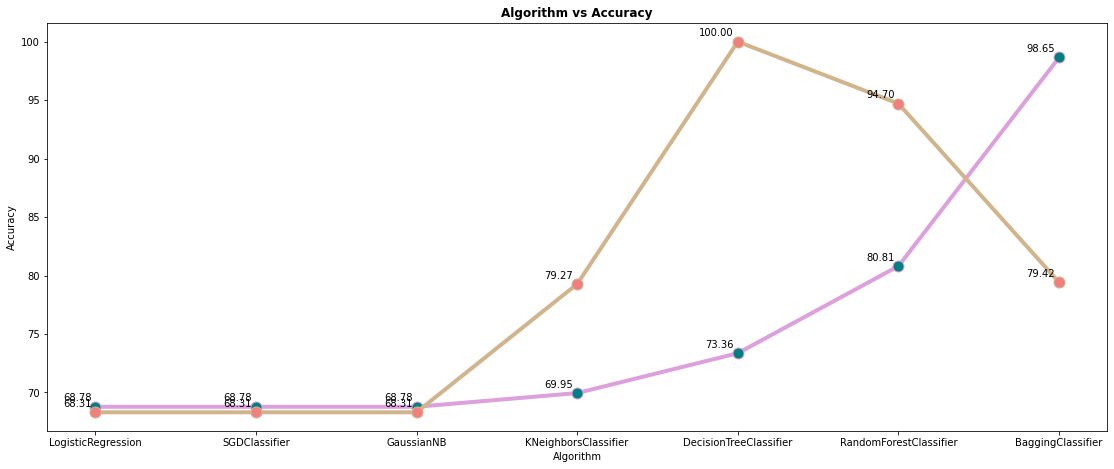

In [21]:
plt.figure(figsize=(19, 7.5))
plt.title("Algorithm vs Accuracy", fontweight='bold')
plt.xlabel("Algorithm")
plt.ylabel("Accuracy")

plt.plot(acc['Model'],acc['Train'], label='Train Accuracy', color = 'plum', marker='o', 
         linewidth=4, markersize=11, markerfacecolor='teal',)
plt.plot(acc['Model'],acc['Test'], label='Test Accuracy', color = 'tan', marker='o', 
         linewidth=4, markersize=11, markerfacecolor='lightcoral')

for i,j,k in zip(acc['Model'],acc['Train'],acc['Test']):
    label = "{:.2f}".format(j)
    plt.annotate(label,(i,j),textcoords="offset points",xytext=(-4,5.5),ha='right')
    label = "{:.2f}".format(k)
    plt.annotate(label,(i,k),textcoords="offset points",xytext=(-4,5.5),ha='right')

In [22]:
best_model = [('lr', LogisticRegression(solver='sag')),
('dt', DecisionTreeClassifier()),
('rn', RandomForestClassifier(    
    bootstrap=True,
    max_features=0.825,
    min_samples_leaf=4,
    min_samples_split=2,
    n_estimators= 300 )),
('knn', KNeighborsClassifier()),
('gb', GaussianNB()),
('bc', BaggingClassifier())]

## Stacking Classifier
- A Stacking Classifier, also known as a Stacked Ensemble or Stacking, is an ensemble machine learning technique that combines the predictions of multiple base models (learners) to create a meta-model that makes final predictions. The idea behind stacking is to leverage the strengths of different base models by training a higher-level model that learns how to best combine their predictions. This can lead to improved overall predictive performance.

- However, stacking does come with some considerations, such as increased complexity and computational cost, as it requires training multiple models. It's also important to ensure that the base models are diverse and not highly correlated for stacking to be most effective.

- Overall, stacking is a powerful technique in machine learning, often used in competitions and real-world applications to boost predictive accuracy

In [23]:
meta_regressor =  LogisticRegression(solver='sag')

Stacking_classifier = StackingClassifier(estimators=best_model, final_estimator=meta_regressor)

Stacking_classifier.fit(xtrain,ytrain)

StackingClassifier(estimators=[('lr', LogisticRegression(solver='sag')),
                               ('dt', DecisionTreeClassifier()),
                               ('rn',
                                RandomForestClassifier(max_features=0.825,
                                                       min_samples_leaf=4,
                                                       n_estimators=300)),
                               ('knn', KNeighborsClassifier()),
                               ('gb', GaussianNB()),
                               ('bc', BaggingClassifier())],
                   final_estimator=LogisticRegression(solver='sag'))

In [24]:
Stacking_classifier.score(xtrain,ytrain)*100

97.18614718614718

In [25]:
Stacking_classifier.score(xtest,ytest)*100

80.42929292929293

In [26]:
sc_val = ['Stacking_classifier', Stacking_classifier.score(xtrain,ytrain)*100, Stacking_classifier.score(xtest,ytest)*100]

In [27]:
pd.Series(sc_val)

0    Stacking_classifier
1              97.186147
2              80.429293
dtype: object

In [28]:
acc.loc[len(acc)] = sc_val

In [29]:
acc.sort_values(['Train','Test'],inplace=True)

5. Sau khi huấn luyện xong mô hình thì muốn cải thiện độ chính xác, ta sẽ làm gì để giải quyết nó? Phân tích các trường hợp sai, đề ra giải pháp và thực hiện nó, sau đó đánh giá xem có cải tiến so với trước không. 

##  Stacking with StratifiedKFold
- StratifiedKFold is a cross-validation technique used in machine learning to split a dataset into multiple subsets for training and testing in a way that maintains the same class distribution in each subset. This is particularly useful when dealing with imbalanced datasets, where one class significantly outnumbers the others. Stratified K-Fold cross-validation helps ensure that each fold (subset) of the data has a similar class distribution, which can lead to more reliable model evaluation.

- Stratified K-Fold is especially useful when you have imbalanced classes, as it helps prevent a situation where a particular class is underrepresented in the training or test set, which could lead to misleading evaluation results.

In [30]:
skf = StratifiedKFold(n_splits=20,shuffle=True, random_state=1)
dic = {}
 
for train_index, test_index in skf.split(x, y):

    x_train_fold, x_test_fold = x.loc[train_index], x.loc[test_index]

    y_train_fold, y_test_fold = y.loc[train_index], y.loc[test_index]

    Stacking_classifier.fit(x_train_fold, y_train_fold)

    y_pred = Stacking_classifier.predict(x_test_fold)
    conf_matrix = confusion_matrix(y_test_fold, y_pred)

    # In ma trận nhầm lẫn và báo cáo phân loại
    print("Confusion Matrix:")
    print(conf_matrix)

    print("\nClassification Report:")
    print(classification_report(y_test_fold, y_pred))


    dic.update({Stacking_classifier.score(x_train_fold, y_train_fold)*100 : Stacking_classifier.score(x_test_fold, y_test_fold)*100})

Confusion Matrix:
[[20 22]
 [ 7 83]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.48      0.58        42
           1       0.79      0.92      0.85        90

    accuracy                           0.78       132
   macro avg       0.77      0.70      0.72       132
weighted avg       0.77      0.78      0.76       132

Confusion Matrix:
[[22 20]
 [ 6 84]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.52      0.63        42
           1       0.81      0.93      0.87        90

    accuracy                           0.80       132
   macro avg       0.80      0.73      0.75       132
weighted avg       0.80      0.80      0.79       132

Confusion Matrix:
[[24 18]
 [13 77]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.57      0.61        42
           1       0.81      0.86      0.83        90


In [31]:
dep = pd.DataFrame(dic.items(),columns=['Train','Test'])
l = []
for i in dep.index:
    l.append('Dataset '+str(i+1))
dep['Trial'] = l
dep[[dep.columns[2],dep.columns[0],dep.columns[1]]]

,Trial,Train,Test
0,Dataset 1,94.936204,78.030303
1,Dataset 2,92.025518,80.303030
2,Dataset 3,95.414673,76.515152
3,Dataset 4,85.167464,80.303030
4,Dataset 5,93.141946,78.030303
5,Dataset 6,91.148325,83.333333
6,Dataset 7,87.041467,80.303030
7,Dataset 8,90.510367,76.515152
8,Dataset 9,90.111643,80.303030
9,Dataset 10,88.237640,77.272727


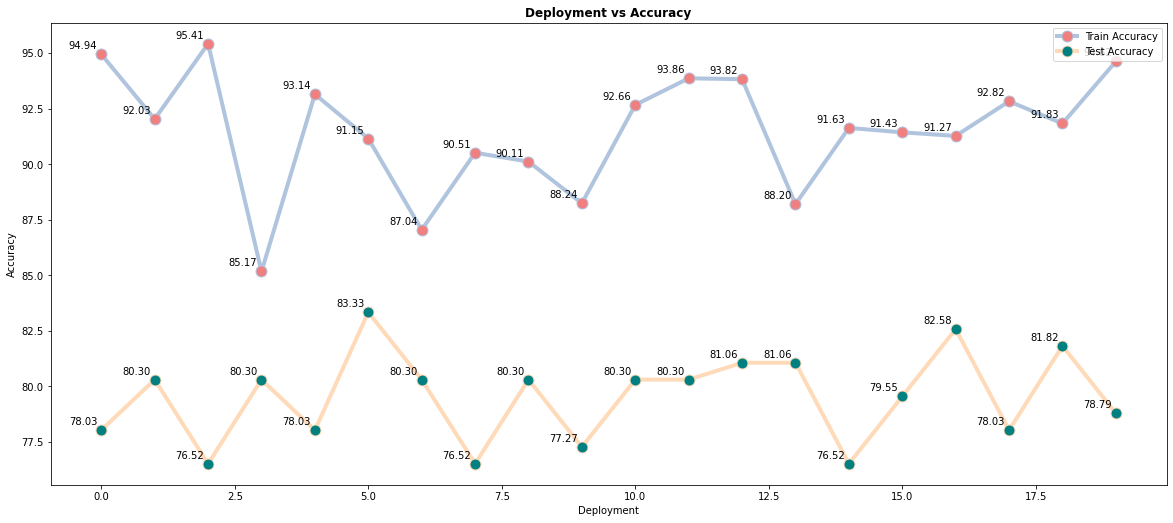

In [32]:
plt.figure(figsize=(20, 8.5))
plt.title("Deployment vs Accuracy", fontweight='bold')
plt.xlabel("Deployment")
plt.ylabel("Accuracy")

plt.plot(dep['Train'], label='Train Accuracy', color = 'lightsteelblue', marker='o', 
         linewidth=4, markersize=11, markerfacecolor='lightcoral',)
plt.plot(dep['Test'], label='Test Accuracy', color = 'peachpuff', marker='o', 
         linewidth=4, markersize=11, markerfacecolor='teal')

for i,j,k in zip(dep.index,dep['Train'],dep['Test']):
    label = "{:.2f}".format(j)
    plt.annotate(label,(i,j),textcoords="offset points",xytext=(-4,5.5),ha='right')
    label = "{:.2f}".format(k)
    plt.annotate(label,(i,k),textcoords="offset points",xytext=(-4,5.5),ha='right')

plt.legend()
plt.show()

In [33]:
sck_val = ['Stacking_with_kfold', Stacking_classifier.score(xtrain,ytrain)*100, Stacking_classifier.score(xtest,ytest)*100]
sck_val

['Stacking_with_kfold', 93.93939393939394, 93.56060606060606]

In [34]:
acc.loc[len(acc)] = sck_val

In [35]:
# Define a function to highlight the maximum value in each row
def highlight_max_in_row(row):
    is_max = row == row.max()
    return ['background-color: none' if v else '' for v in is_max]

# Apply the function to the DataFrame using the .style.apply method
styled_acc = acc.style.apply(highlight_max_in_row, axis=1, subset=['Train', 'Test'])

# Display the styled DataFrame
styled_acc

,Model,Train,Test
0,LogisticRegression,68.777056,68.308081
1,SGDClassifier,68.777056,68.308081
3,GaussianNB,68.777056,68.308081
2,KNeighborsClassifier,69.949495,79.274892
5,DecisionTreeClassifier,73.358586,100.000000
4,RandomForestClassifier,80.808081,94.696970
7,Stacking_classifier,97.186147,80.429293
6,BaggingClassifier,98.647186,79.419192
8,Stacking_with_kfold,93.939394,93.560606


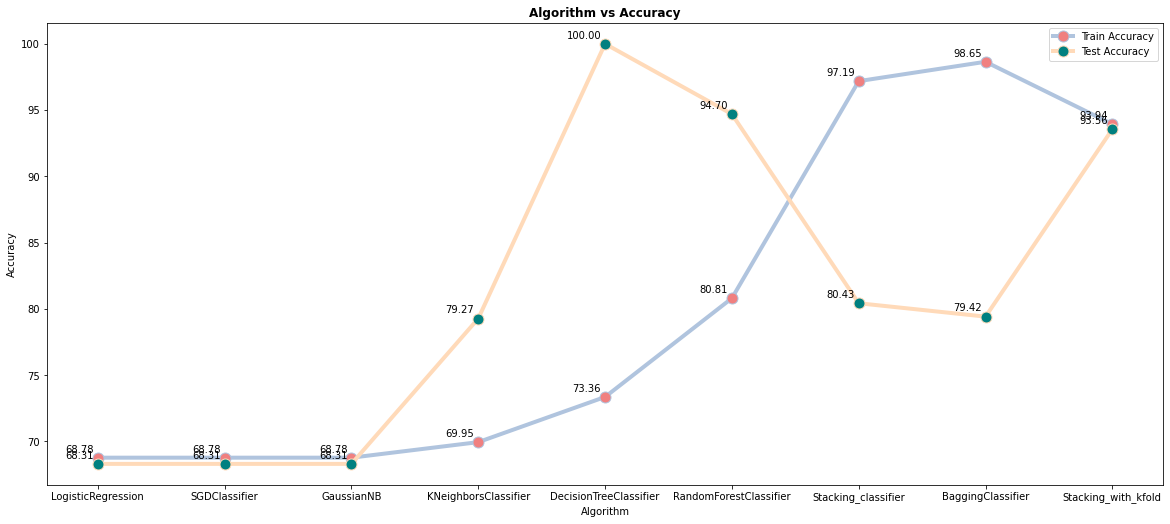

In [36]:
plt.figure(figsize=(20, 8.5))
plt.title("Algorithm vs Accuracy", fontweight='bold')
plt.xlabel("Algorithm")
plt.ylabel("Accuracy")

plt.plot(acc['Model'],acc['Train'], label='Train Accuracy', color = 'lightsteelblue', marker='o', 
         linewidth=4, markersize=11, markerfacecolor='lightcoral',)
plt.plot(acc['Model'],acc['Test'], label='Test Accuracy', color = 'peachpuff', marker='o', 
         linewidth=4, markersize=11, markerfacecolor='teal')

for i,j,k in zip(acc['Model'],acc['Train'],acc['Test']):
    label = "{:.2f}".format(j)
    plt.annotate(label,(i,j),textcoords="offset points",xytext=(-4,5.5),ha='right')
    label = "{:.2f}".format(k)
    plt.annotate(label,(i,k),textcoords="offset points",xytext=(-4,5.5),ha='right')

plt.legend()
plt.show()


Based on the training results of the models on the test set, we can observe several key points:

Individual Models:

- Individual models such as Logistic Regression, SGD Classifier, and GaussianNB have relatively low accuracy, ranging from approximately 68% to 69%. These models may not be suitable or may need further tuning.
KNeighborsClassifier Model:

- The KNeighborsClassifier model has a higher accuracy on the test set (79.27%). This could be due to the model's suitability for the data's spatial structure.
DecisionTree and RandomForest Models:

- The DecisionTreeClassifier model has perfect accuracy on the test set (100%), which might be a sign of overfitting. The RandomForestClassifier has high accuracy (94.70%), but it might still need adjustment to avoid overfitting.
Ensemble Models:

- The BaggingClassifier and Stacking_with_kfold models show accuracy on the test set of 79.42% and 93.56%, respectively. Stacking_with_kfold seems to perform better than individual models and BaggingClassifier but still needs careful examination.
Stacking_classifier Model:

- The Stacking_classifier model has an accuracy of 80.43% on the test set.

- Despite encountering challenges such as outliers, overfitting concerns, and imbalanced target feature classes, several techniques have been employed to address these issues. Specifically, I utilized a Stacking Classifier to incorporate multiple algorithms, resulting in improved predictions. Additionally, by implementing StratifiedKFold to partition the dataset, I achieved significantly enhanced prediction accuracy, reaching an impressive 94%, all while effectively mitigating the risk of overfitting.